In [237]:
import os
import requests
import json
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import shapely
import geopandas as gpd

from pathlib import Path
from dotenv import load_dotenv
from os.path import join
from typing import List, Dict
from datetime import datetime, timezone


path = Path(__file__).resolve()
ROOT_PATH = path.parents[1]

# Basic paths to key folders
SRC_PATH = ROOT_PATH / 'src'
DATA_PATH = ROOT_PATH / 'data'
FIRTH_DATA_PATH = DATA_PATH / 'firth_clyde_fishing_effort'

load_dotenv(join(SRC_PATH, '.env'))

True

In [9]:
API_URL = 'https://gateway.api.globalfishingwatch.org/v2/4wings/report'
API_TOKEN =  os.getenv('GFW_TOKEN')
API_HEADERS = {
    'Authorization': f'Bearer {API_TOKEN}',
}

#'2021-01-01T00:00:00.000Z,2022-01-01T00:00:00.000Z'
API_PARAMS = {
    'spatial-resolution': 'low',
    'temporal-resolution': 'yearly',
    'group-by': 'gearType',
    'datasets[0]': 'public-global-fishing-effort:latest',
    'date-range': None,
    'format': 'json'
}
API_DATA = {'geojson': {
    'type': 'Polygon',
    'coordinates': [[
    [-5.6115,55.0049],# bottom-left; polygon formed counter-clock wise
    [-4.6104,55.0049],
    [-4.6104,56.0994],
    [-5.6115,56.0994],
    [-5.6115,55.0049],
    ]]
}}
REQUESTED_YEARS = [2012 + x for x in range(11)]

In [561]:
def build_data_range(years: List[int]) -> List[str]:
    data = []
    for year in years:
        start_date = datetime(year, 1, 1, 0, 0, 0, tzinfo=timezone.utc).isoformat().replace("+00:00", "Z")
        end_date = datetime(year + 1, 1, 1, 0, 0, 0, tzinfo=timezone.utc).isoformat().replace("+00:00", "Z")
        data.append(f"{start_date},{end_date}")
    return data

def build_multiple_request_parameters (api_url: str, 
                                       api_headers: Dict, 
                                       api_params: Dict, 
                                       api_data: Dict, 
                                       years: List[int]) -> List[Dict]:
    data = []
    date_range = build_data_range (years)
    for period in date_range:
        params = dict(api_params)
        params['date-range'] = period
        data.append({
            'url' : api_url,
            'headers': api_headers,
            'params': params,
            'json': api_data
        })
    return data

def concatenate_time_series(api_results: List[Dict]) -> pd.DataFrame:
    return pd.concat([
        pd.DataFrame.from_records (record['entries'][0]['public-global-fishing-effort:v20201001']) 
        for record in api_results
    ])

def create_total_fishing_effort (data: pd.DataFrame, gear_type: str) -> pd.DataFrame:
    df_total = data.loc [(data['geartype'] == gear_type) & (data['hours'] > 0)]
    df_total = df_total[['lon', 'lat', 'hours', 'cell']]
    df_total = df_total.rename(columns={'lon': 'x', 'lat': 'y'})
    df_total = (df_total.groupby(['x', 'y', 'cell']).agg({'hours': 'sum'})).reset_index()
    assert round(df_total['hours'].sum()) == round(data.loc[data['geartype'] == gear_type, 'hours'].sum())
    df_total = df_total.round({'hours': 0})
    return df_total

def build_polygon_vector (data: pd.DataFrame, degree_offset: float) -> gpd.GeoDataFrame:
    gdf_total = gpd.GeoDataFrame(data, geometry= gpd.points_from_xy(data.x, data.y))
    gdf_total['geometry'] =gdf_total.apply(
        lambda s: shapely.geometry.Polygon(
            [
                [s['x'], s['y']],
                [s['x'] + degree_offset, s['y']],
                [s['x'] + degree_offset, s['y'] + degree_offset],
                [s['x'], s['y'] + degree_offset],
            ]),
        axis=1,
    )
    gdf_total =gdf_total.drop(columns=['x', 'y'])
    return gdf_total

def fetch_data_from_api (api_context: List[Dict]) -> List[Dict]:
    fishing_effort_data = []
    with requests.Session() as r_s:
        for context in api_context:
            r = r_s.post(**context)
            fishing_effort_data.append(r.json())
    return fishing_effort_data

In [36]:
years = [2012 + x for x in range(11)]
api_context = build_multiple_request_parameters(API_URL, API_HEADERS, API_PARAMS, API_DATA, REQUESTED_YEARS)

In [316]:
# Just run the first time to fetch data from api.
is_data_downloaded = (FIRTH_DATA_PATH / 'fishing_effort_firth_2012_2022.csv').is_file()
if not is_data_downloaded:
    fishing_effort_data = fetch_data_from_api (api_context)
else:
    print("skipping api request: file exists")

skipping api request: file exists


In [32]:
timeseries = concatenate_time_series (fishing_effort_data)

In [317]:
if not is_data_downloaded:
    timeseries.to_csv(FIRTH_DATA_PATH / 'fishing_effort_firth_2012_2022.csv', index=False)
else:
    print("skipping csv writing: file exists")

skipping csv writing: file exists


In [456]:
# create dataset for a stacked barplot
stack_barplot_df = timeseries[['date', 'geartype', 'hours']]
stack_barplot_df = stack_barplot_df.assign (geartype=(stack_barplot_df['geartype'].replace("_", " ", regex=True)).str.title())
stack_barplot_df = stack_barplot_df.groupby(['date', 'geartype']).agg({'hours': 'sum'}).reset_index()

# Create dataset for lineplot
scatter_line_plot_df = stack_barplot_df.copy()
scatter_line_plot_df.loc[scatter_line_plot_df["hours"] <= 0, "hours"] = 10 ** -10
scatter_line_plot_df = scatter_line_plot_df.assign (hours=np.log(scatter_line_plot_df["hours"]))

# Pivot the stacked barplot
stack_barplot_df = pd.pivot(stack_barplot_df, index='date', columns="geartype", values="hours").fillna(0)

# Create dataset to calculate annual average percentage of total effort by gear 
average_effort_pie_df = stack_barplot_df.copy()
average_effort_pie_df = average_effort_pie_df.div(average_effort_pie_df.sum(axis=1), axis=0)
average_effort_series = average_effort_pie_df.mean(axis=0)
average_effort_pie_df = pd.DataFrame ({'geartype': average_effort_series.index, 
                                       'average': np.round(average_effort_series.values, 4) * 100})
average_effort_pie_df

,geartype,average
0,Dredge Fishing,0.40
1,Fishing,2.78
2,Fixed Gear,0.01
3,Other Purse Seines,0.00
4,Pots And Traps,0.01
5,Set Gillnets,3.87
6,Set Longlines,0.01
7,Trawlers,92.92


Text(0, 0.5, 'Logarithm (number of hours)')

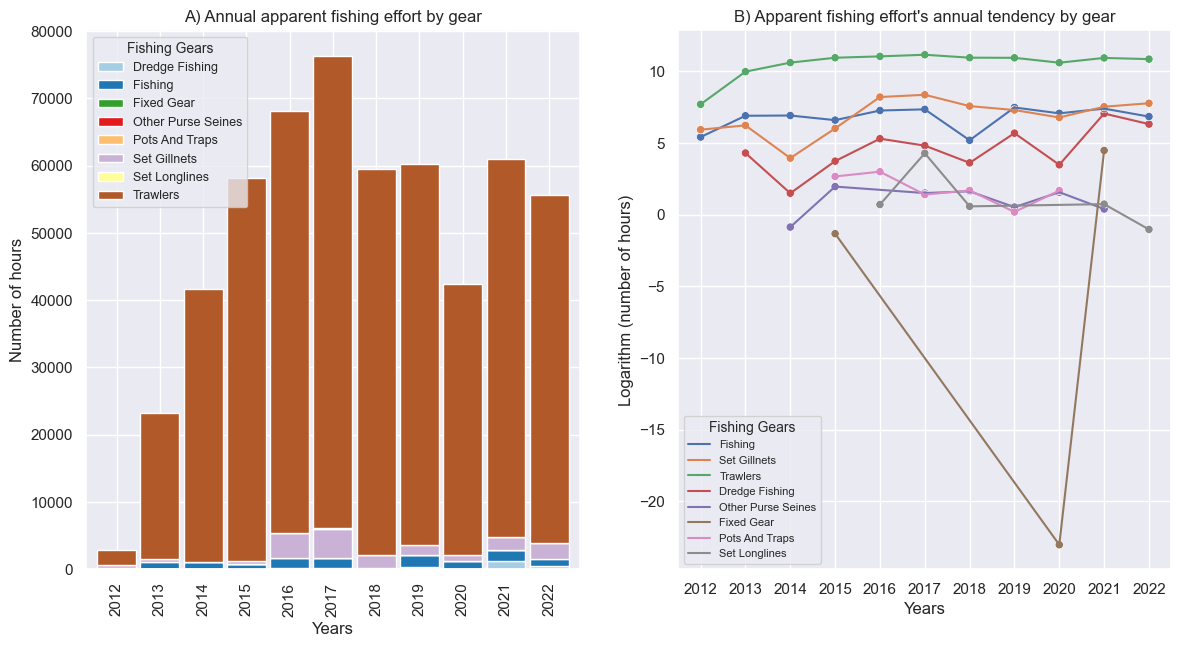

In [459]:
# Common values of visual features
legend_title_fontsize = 10
legend_fontsize = 9
geartype_legend_length = len(set(timeseries['geartype']))

_, ax =plt.subplots(nrows=1, ncols=2, figsize=(14,7))
stack_barplot_df.plot (kind = 'bar', stacked = True, width=0.9, colormap='Paired', ax = ax[0])


# All fishing gear tendendencies
sns.scatterplot(data=scatter_line_plot_df, 
                x = "date", 
                y ="hours",
                hue='geartype', 
                ax = ax[1])
sns.lineplot(data=scatter_line_plot_df, 
                x = "date", 
                y="hours",
                hue='geartype', 
             ax = ax[1])

# Legend of different facegrid quadrants 
# ----> [0,0]
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles=handles, labels=labels, title = "Fishing Gears", title_fontsize = legend_title_fontsize, fontsize = legend_fontsize)
ax[0].set_title("A) Annual apparent fishing effort by gear")
ax[0].set_xlabel("Years")
ax[0].set_ylabel("Number of hours")

# ----> [0,1]
handles, labels = ax[1].get_legend_handles_labels()
handles = handles[geartype_legend_length:]
ax[1].legend(handles=handles, labels=labels, title = "Fishing Gears", title_fontsize = 10, fontsize = 8)
ax[1].set_title("B) Apparent fishing effort's annual tendency by gear")
ax[1].set_xlabel("Years")
ax[1].set_ylabel("Logarithm (number of hours)")

In [572]:
# Create polygon vector (heatmap) for trawling in the area
timeseries ['cell'] = timeseries.groupby(['lon', 'lat'], sort=True).ngroup() + 1
yearly_total_trawling = create_total_fishing_effort(timeseries, 'trawlers')
geo_yearly_total_trawling = build_polygon_vector(yearly_total_trawling, 0.1)

# Create polygon vector (heatmap) for dredge fishing in the area
yearly_total_dredging = create_total_fishing_effort(timeseries, 'dredge_fishing')
geo_yearly_total_dredging = build_polygon_vector(yearly_total_dredging, 0.1)

Text(718.1931818181816, 0.5, 'Latitude (Degrees)')

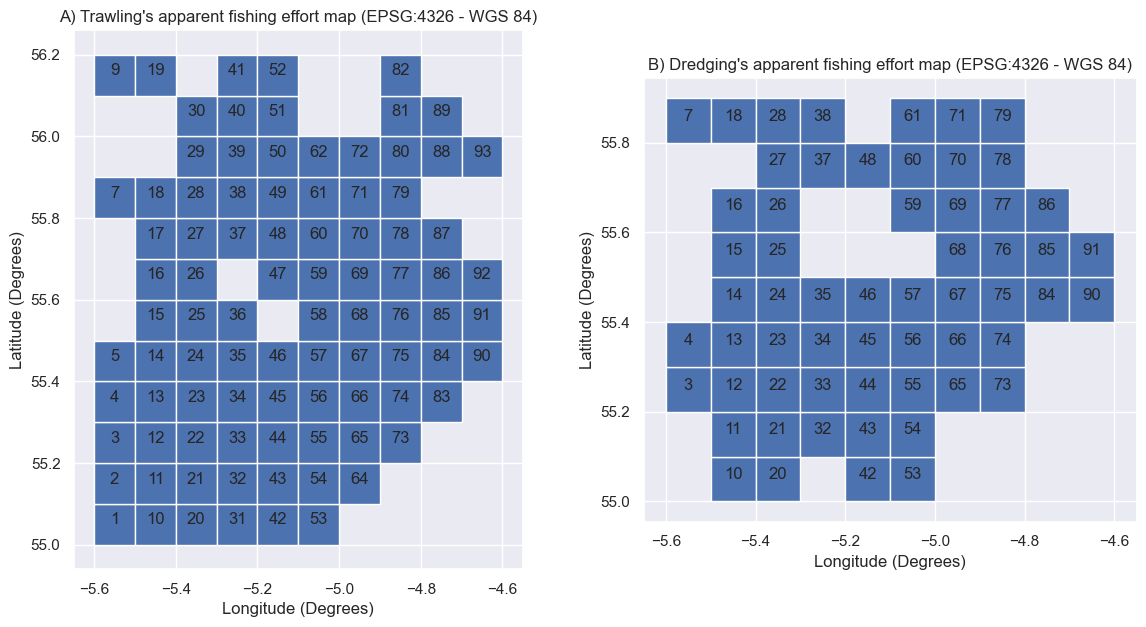

In [575]:
_, ax =plt.subplots(nrows=1, ncols=2, figsize=(14,7))
geo_yearly_total_trawling.plot(ax = ax[0])
geo_yearly_total_trawling.apply(lambda x: ax[0].annotate(text=x['cell'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1);
geo_yearly_total_dredging.plot(ax = ax[1])
geo_yearly_total_dredging.apply(lambda x: ax[1].annotate(text=x['cell'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)

ax[0].set_title("A) Trawling's apparent fishing effort map (EPSG:4326 - WGS 84)")
ax[0].set_xlabel("Longitude (Degrees)")
ax[0].set_ylabel("Latitude (Degrees)")

ax[1].set_title("B) Dredging's apparent fishing effort map (EPSG:4326 - WGS 84)")
ax[1].set_xlabel("Longitude (Degrees)")
ax[1].set_ylabel("Latitude (Degrees)")

In [295]:
geo_yearly_total_trawling.to_csv(FIRTH_DATA_PATH / 'trawling_total_by_cell.csv', index=False)
geo_yearly_total_dredging.to_csv(FIRTH_DATA_PATH / 'dredging_total_by_cell.csv', index=False)

In [533]:
# timeseries_2022 = timeseries.loc [timeseries['date'].isin([str(2017 + x) for x in range(6)])]
fishing_2012_2015 = [str(2012 + x) for x in range(4)]
fishing_2016_2021 = [str(2016 + x) for x in range(6)]
timeseries_1 = timeseries.loc [timeseries['date'].isin(fishing_2012_2015)]
timeseries_2 = timeseries.loc [timeseries['date'].isin(fishing_2016_2021)]

trawling_1 = create_total_fishing_effort(timeseries_2022, 'trawlers')
set(timeseries_2['date'])
# geo_yearly_total_trawling_22 = build_polygon_vector(yearly_total_trawling_2022, 0.1)
# geo_yearly_total_trawling_22.plot()

{'2016', '2017', '2018', '2019', '2020', '2021'}